TODO:
1. EOS
2. Beam search  
//////
1. CNN - done
2. plot - done
3. BLEU - done
4. Evaluation - done
5. early stopping - done


To run this notebook for actual analysis:  
remove breaker in train_model  
increase hidden size  
increase eva_every  


In [1]:
from __future__ import unicode_literals, print_function, division
import pickle as pkl
from io import open
import unicodedata
import string
import re
import random
import torch
import sacrebleu
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import time
import math
from sacrebleu import corpus_bleu

device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Data Pre-processing

In [2]:
SOS_token = 0
EOS_token = 1
PAD_IDX = 2
UNK_IDX = 3
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2:"PAD", 3:"UNK"}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def normalizeString(s):
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"&apos;m", r"am", s)
    s = re.sub(r"&apos;s", r"is", s)
    s = re.sub(r"&apos;re", r"are", s)
    s = re.sub(r"&apos;", r"", s)
    return s

In [4]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.5)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()


In [5]:
def loadingLangs(sourcelang, targetlang, setname):
    input_ls = []
    output_ls = []
    print('Reading lines...')
    # Read the file 
    with open('data/iwslt-%s-%s/%s.tok.%s'%(sourcelang, targetlang, setname,sourcelang)) as f:
        for line in f.readlines():
            input_ls.append([normalizeString(word) for word in line.split()])
    with open('data/iwslt-%s-%s/%s.tok.%s'%(sourcelang, targetlang, setname,targetlang)) as f:
        for line in f.readlines():
            output_ls.append([normalizeString(word) for word in line.split()])
    pairs = list(zip(input_ls, output_ls))
    print('Read %s sentence pairs'%(len(input_ls)))
    input_lang = Lang(sourcelang)
    output_lang = Lang(targetlang)
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [6]:
source_tra, target_tra, pairs_tra = loadingLangs('zh', 'en', 'train')
source_val, target_val, pairs_val = loadingLangs('zh', 'en', 'dev')
source_tes, target_tes, pairs_tes = loadingLangs('zh', 'en', 'test')

Reading lines...
Read 213377 sentence pairs
Counting words...
Counted words:
zh 88918
en 69063
Reading lines...
Read 1261 sentence pairs
Counting words...
Counted words:
zh 6133
en 4015
Reading lines...
Read 1397 sentence pairs
Counting words...
Counted words:
zh 5215
en 3518


In [7]:
print("95% of chinese sentences length = {0}".format(np.percentile([len(x[0]) for x in pairs_tra], 95)))
print("95% of english sentences length = {0}".format(np.percentile([len(x[1]) for x in pairs_tra], 95)))
print(random.choice(pairs_tra))

95% of chinese sentences length = 44.0
95% of english sentences length = 48.0
(['我们', '只是', '关心', '天气', '是', '好', '是', '坏'], ['We', 'just', 'think', 'of', 'good', 'weather', 'and', 'bad', 'weather', ' .'])


## Dataset

In [8]:
MAX_SENT_LEN = 50
BATCH_SIZE = 32

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_IDX for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair,source,target):
    input_lang = source
    output_lang = target
    input_tensor = tensorFromSentence(input_lang, pair[0]).reshape((-1))
    target_tensor = tensorFromSentence(output_lang, pair[1]).reshape((-1))
    return (input_tensor, input_tensor.shape[0], target_tensor, target_tensor.shape[0])

In [10]:
class NMTDataset(Dataset):
    def __init__(self, source, target, pairs):
        self.source = source
        self.target = target
        self.pairs = pairs
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        inp_ten, inp_len, tar_ten, tar_len = tensorsFromPair(self.pairs[key], self.source, self.target)
        item = {}
        item['inputtensor'] = inp_ten[:MAX_SENT_LEN]
        item['inputlen'] = min(inp_len, MAX_SENT_LEN)
        item['targettensor'] = tar_ten[:MAX_SENT_LEN]
        item['targetlen'] = min(tar_len, MAX_SENT_LEN)
        return item

In [11]:
train_data = NMTDataset(source_tra, target_tra, pairs_tra)
val_data = NMTDataset(source_tra, target_tra, pairs_val)# should use index2word from training. Jin modified
test_data = NMTDataset(source_tra, target_tra, pairs_tes)# should use index2word from training .Jin modified

## Dataloader

In [12]:
#collate function

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    src_data, tar_data, src_len, tar_len = [], [], [], []
    for datum in batch:        
        src_datum = np.pad(np.array(datum['inputtensor']),
                                pad_width=((0,MAX_SENT_LEN-datum['inputlen'])),
                                mode="constant", constant_values=PAD_IDX)
        tar_datum = np.pad(np.array(datum['targettensor']),
                                pad_width=((0,MAX_SENT_LEN-datum['targetlen'])),
                                mode="constant", constant_values=PAD_IDX)
        src_data.append(src_datum)
        tar_data.append(tar_datum)
        src_len.append(datum['inputlen'])
        tar_len.append(datum['targetlen'])
    return [torch.from_numpy(np.array(src_data)).to(device),torch.from_numpy(np.array(tar_data)).to(device),
               torch.from_numpy(np.array(src_len)).to(device),torch.from_numpy(np.array(tar_len)).to(device)]

In [13]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,shuffle=True, collate_fn=collate_func)
val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=BATCH_SIZE,shuffle=False, collate_fn=collate_func)

In [14]:
# sample data loader
count = 0
for data in train_loader:
    count+=1
    print('input sentence batch: ')
    print(data[0])
    print('input batch dimension: {}'.format(data[0].size()))
    print('target sentence batch: ')
    print(data[1])
    print('target batch dimension: {}'.format(data[1].size()))
    print('input sentence len: ')
    print(data[2])
    print('target sentence len: ')
    print(data[3])
    if count == 1:
        break

input sentence batch: 
tensor([[  277,  6941,  1067,  ...,     2,     2,     2],
        [   16,   178,  2547,  ...,     2,     2,     2],
        [  107,   416, 27409,  ...,     2,     2,     2],
        ...,
        [ 1330,   173,    49,  ...,     2,     2,     2],
        [   75,   277, 37447,  ...,     2,     2,     2],
        [  446,   110,   274,  ...,     2,     2,     2]])
input batch dimension: torch.Size([32, 50])
target sentence batch: 
tensor([[   74,  2692,    23,  ...,     2,     2,     2],
        [   51,    52,  4588,  ...,     2,     2,     2],
        [ 4660,   264,    63,  ...,     2,     2,     2],
        ...,
        [ 1197,    16,     5,  ...,     2,     2,     2],
        [  156,     6, 13503,  ...,     2,     2,     2],
        [  146,   446,     5,  ...,     2,     2,     2]])
target batch dimension: torch.Size([32, 50])
input sentence len: 
tensor([18, 42, 25, 50,  8, 50, 14, 15, 25, 21, 28, 21, 19,  2, 13, 17,  4, 34,
        10,  7, 30, 17, 17, 16, 14, 18,

----------------------

## Model

In [15]:

hyper = {
    'HIDDEN_SIZE': 16,
    'LR': 0.01,
    'EVA_EVERY': 2,
    'DROP_OUT': 0.3,
    'TEACHER_RATIO': 0.5,
    'N_LAYERS': 1,
    'KER_SIZE': 3,
    'NUM_EPOCHS': 2   
}


In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True) 
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
    def initHidden(self,batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, device=device) 
    
    def forward(self, input, hidden):
        batch_size = input.size()[0]
        embedded = self.embedding(input).view(1, batch_size, -1)   
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)  
        output = self.fc1(output)
        return output, hidden

In [17]:
class EncoderCNN(nn.Module):
    def __init__(self, input_size, hidden_size, ker_size=3, n_layers=1):
        super(EncoderCNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=ker_size, padding=(ker_size-1)//2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=ker_size, padding=(ker_size-1)//2)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
    
    
    def forward(self, input, hidden):
        seq_len, batch_size = input.size()
        embedded = self.embedding(input) 
        output = embedded
        output = self.conv1(output.transpose(1,2)).transpose(1,2)
        output = F.relu(output.contiguous().view(-1, output.size(-1))).view(batch_size, seq_len, output.size(-1))
        output = torch.nn.functional.max_pool1d(output.transpose(1,2), seq_len).transpose(1,2)
        output = output.view(-1, output.size(-1))
        output = self.fc1(output)
        return output, output
    
    def initHidden(self,batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [18]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_SENT_LEN, n_layers=1):

        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.n_layers = n_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        input = input.view(1,-1)
        seq_len, batch_size = input.size()
        output= self.embedding(input).view(1, batch_size, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden

In [19]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_SENT_LEN):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        input = input.view(1,-1)
        seq_len, batch_size = input.size()
        embedded = self.embedding(input).view(1, batch_size, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)   
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs.transpose(0,1))
        
        output = torch.cat((embedded[0], attn_applied.transpose(0,1)[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

-----------------------------------------------------------

## Train

In [20]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion, mode_dec=None, mode_enc=None):
    
    hidden_size = hyper['HIDDEN_SIZE']
    learning_rate = hyper['LR']
    dropout_p = hyper['DROP_OUT']
    teacher_forcing_ratio = hyper['TEACHER_RATIO']
    n_layers = hyper['N_LAYERS']
    ker_size = hyper['KER_SIZE']
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0) 
    target_length = target_tensor.size(0)
    batch_size = input_tensor.size()[1]
    encoder_hidden = encoder.initHidden(batch_size)
    encoder_outputs = torch.zeros(target_length, batch_size, encoder.hidden_size, device=device) 
    loss = 0
    
    # feed-forward layer resulting encoder outputs, ei refers to each word token in input sentence
    for ei in range(input_length):
        if mode_enc == 'cnn':
            if ei >= 10:
                encoder_output, encoder_hidden = encoder(
                    input_tensor[:ei], encoder_hidden)

                encoder_outputs[ei-10] = encoder_output 
        else: 
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)  
            encoder_outputs[ei] = encoder_output[0] 

    if mode_enc == 'cnn':
        encoder_hidden = nn.Linear(hidden_size,hidden_size)(encoder_hidden).unsqueeze(0)
    else:
        encoder_hidden = nn.Linear(2*hidden_size,hidden_size)(
            torch.cat((encoder_hidden[0],encoder_hidden[1]),dim = 1)).unsqueeze(0)
    
    decoder_input = torch.tensor([[SOS_token]*batch_size], device=device)  

    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
  
        for di in range(target_length):
            if mode_dec == 'attn':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                
            
            decoder_input = target_tensor[di]  

            loss += criterion(decoder_output, target_tensor[di]) 

            
    else:
  
        for di in range(target_length):
            if mode_dec == 'attn':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.topk(1)
 
            decoder_input = topi.squeeze().detach()
            
  
            loss += criterion(decoder_output, target_tensor[di])

    loss.backward()
    encoder_optimizer.step() 
    decoder_optimizer.step()

    return loss.item() / target_length

------------------------------------------------------------

## Evaluate

In [21]:
def convert_idx_2_sent(pred_tensor, truth_tensor,lang_obj):
    pred_word_list = []
    truth_word_list = []
    for i in pred_tensor:
        if i.item() not in set([PAD_IDX,EOS_token,SOS_token]):
            pred_word_list.append(lang_obj.index2word[i.item()])
    for j in truth_tensor:
        if j.item() not in set([PAD_IDX,EOS_token,SOS_token]):
            truth_word_list.append(lang_obj.index2word[j.item()])
    pred_sent = (' ').join(pred_word_list)
    truth_sent = (' ').join(truth_word_list)
    return pred_sent, truth_sent

In [22]:
def bleu(corpus, truths):
    '''
    corpus: list, NBs * BATCHSIZE * MAX_LEN
    truths: list, NBs * BATCHSIZE * MAX_LEN
    
    return: array of length NBs, avg blue score for each batch
    '''
    n = len(corpus)
    bleus = [0]*n
    for i in range(n):
        pred, true = corpus[i], truths[i]
        sumbleu = 0.0
        for j in range(len(corpus[i])):
            pred_tensor, true_tensor = pred[j], true[j]
            pred_sent, true_sent = convert_idx_2_sent(pred_tensor, true_tensor, target_tra)
            sumbleu += corpus_bleu(true_sent, pred_sent).score
        avgbleu = sumbleu / len(corpus[i])
        bleus[i] = avgbleu
    return bleus

In [23]:
def evaluate(encoder, decoder, data_loader, mode_enc, mode_dec, max_length=MAX_SENT_LEN):
    start = time.time()
    hidden_size = hyper['HIDDEN_SIZE']
    learning_rate = hyper['LR']
    dropout_p = hyper['DROP_OUT']
    teacher_forcing_ratio = hyper['TEACHER_RATIO']
    n_layers = hyper['N_LAYERS']
    ker_size = hyper['KER_SIZE']
    encoder.eval()
    decoder.eval()
    corpus = []
    truths = []
    for i, (input_sentences, target_sentences,len1,len2) in enumerate(data_loader):
#         if i % 5 == 0:
#             print('Time: {}, Step: [{}/{}]'.format(
#                 timeSince(start, i + 1/len(train_loader)), i, len(data_loader)))
        input_tensor = input_sentences.transpose(0,1).to(device)  
        #target_tensor = target_sentences.transpose(0,1).to(device)# Jin modified
        target_tensor = target_sentences.to(device) # Jin modified
        truths.append(target_tensor)
        input_length = input_tensor.size()[0]
        batch_size = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs = encoder_outputs = torch.zeros(max_length, batch_size, encoder.hidden_size, device=device)
        for ei in range(input_length):
            if mode_enc == 'cnn':
                if ei >= 10:
                    encoder_output, encoder_hidden = encoder(
                        input_tensor[:ei], encoder_hidden)

                    encoder_outputs[ei-10] = encoder_output 
            else: 
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden)  
                encoder_outputs[ei] = encoder_output[0] 
        if mode_enc == 'cnn':
            encoder_hidden = nn.Linear(hidden_size,hidden_size)(encoder_hidden).unsqueeze(0)
        else:
            encoder_hidden = nn.Linear(2*hidden_size,hidden_size)(
                torch.cat((encoder_hidden[0],encoder_hidden[1]),dim = 1)).unsqueeze(0)
   
        decoder_hidden = encoder_hidden 
        decoder_input = torch.tensor([[SOS_token]*batch_size], device=device) 
        decoded_words = torch.zeros(batch_size, max_length)
        decoder_attentions = torch.zeros(max_length, max_length)
    
        for di in range(max_length):
            if mode_dec == 'attn':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            decoded_words[:,di] = topi.squeeze()
            decoder_input = topi.squeeze().detach()
        corpus.append(decoded_words)

    #truths = [t.transpose(0,1) for t in truths] # Jin modified 
    return corpus, truths

## Training

In [24]:
def plot_loss_bleu(bleu_score,
                losses):
    
    batches = np.arange(0, len(bleu_score))
    f, axs = plt.subplots(1, 2, figsize=(15,5))
    ax1 = axs[0]
    ax1.plot(batches, losses, label='Validation loss')
    ax1.set_xlabel("number of batches")
#     ax1.plot(batches, validation_loss_history, alpha=0.7, label='Validation Loss')
    ax1.legend(loc='upper right')

    ax2 = axs[1]
    ax2.plot(batches, bleu_score, label='Validation BLEU Score')
    ax2.set_xlabel("number of batches")
#     ax2.plot(batches, validation_acc_history, alpha=0.7, label='Validation Accuracy')
    ax2.legend(loc='upper right')
    plt.show()

In [25]:
def train_model(mode_enc, mode_dec, hyper):
    start = time.time()
    hidden_size = hyper['HIDDEN_SIZE']
    learning_rate = hyper['LR']
    eva_every = hyper['EVA_EVERY']
    dropout_p = hyper['DROP_OUT']
    teacher_forcing_ratio = hyper['TEACHER_RATIO']
    n_layers = hyper['N_LAYERS']
    ker_size = hyper['KER_SIZE']
    num_epoch = hyper['NUM_EPOCHS']
    early_stopping = True
    patience = 3
    required_progress = 0.01
    
    if mode_enc == 'rnn':
        encoder = EncoderRNN(source_tra.n_words, hidden_size, n_layers=n_layers).to(device)
        
    else:
        encoder = EncoderCNN(source_tra.n_words, hidden_size, n_layers=n_layers, ker_size=ker_size).to(device)
       
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    
    if mode_dec == 'attn':
            decoder = AttnDecoder(hidden_size, target_tra.n_words, dropout_p=dropout_p).to(device)
    else:
            decoder = Decoder(hidden_size, target_tra.n_words, dropout_p=dropout_p).to(device)
            
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss() 
    plot_bleu_score_val = []
    plot_losses = []
    loss_total = 0 
    best_score = None
    count = 0
    for epoch in range(1, num_epoch + 1): 
        for i, (input_sentences, target_sentences,len1,len2) in enumerate(train_loader): 
            ### delete break
            if i > 4:
                break
            encoder.train()
            decoder.train()
            input_tensor = input_sentences.transpose(0,1)   
            target_tensor = target_sentences.transpose(0,1) 
            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion, mode_dec=mode_dec, mode_enc=mode_enc)
            loss_total += loss
            if i > 0 and i % eva_every == 0:
                    corpus, truths = evaluate(encoder, decoder, val_loader, max_length=MAX_SENT_LEN, mode_enc=mode_enc, mode_dec=mode_dec)
                    bleu_score_val = bleu(corpus, truths)
                    bleu_score_val_avg = np.mean(bleu_score_val)
                    loss_avg = loss_total / eva_every
                    loss_total = 0
                    plot_losses.append(loss_avg)
                    plot_bleu_score_val.append(bleu_score_val_avg)
                    if best_score is None:
                        best_score = bleu_score_val_avg
                    if bleu_score_val_avg < best_score + required_progress:
                        count += 1
                    elif bleu_score_val_avg > best_score:
                        best_score = bleu_score_val_avg
                        count = 0
                    if early_stopping:
                        if count >= patience:
                            print("earily stop triggered")
                            break
                    print('Time: {0}, Epoch: [{1}/{2}], Step: [{3}/{4}], Train Loss: {5}, BLEU score: {6}'.format(
                        timeSince(start, i + 1/len(train_loader)), epoch, num_epoch, i, 
                        len(train_loader), loss_avg, bleu_score_val_avg))
        
        if early_stopping:
            if count >= patience:
                break
    plot_loss_bleu(plot_bleu_score_val, plot_losses)


RNN+Attn

Time: 3m 1s (- -2m 29s), Epoch: [1/2], Step: [2/6669], Train Loss: 16.432647094726562, BLEU score: 0.18524868077894913
Time: 5m 39s (- -5m 45s), Epoch: [1/2], Step: [4/6669], Train Loss: 10.36534454345703, BLEU score: 1.4079296375564139
Time: 8m 28s (- -5m 45s), Epoch: [2/2], Step: [2/6669], Train Loss: 14.098573608398436, BLEU score: 1.1028777664944347
Time: 10m 52s (- -9m 50s), Epoch: [2/2], Step: [4/6669], Train Loss: 8.682043151855469, BLEU score: 0.2037010210238805


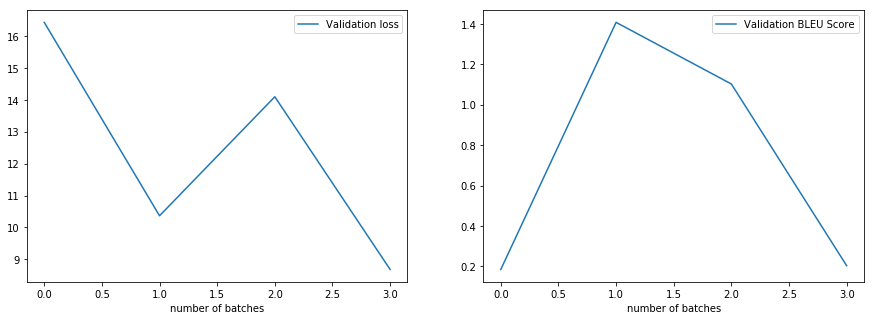

In [27]:
train_model('rnn', 'attn', hyper)

Rnn+noattn

Time: 2m 26s (- -2m 46s), Epoch: [1/2], Step: [2/6669], Train Loss: 16.764436645507814, BLEU score: 0.1874576316196743
Time: 4m 47s (- -4m 24s), Epoch: [1/2], Step: [4/6669], Train Loss: 10.721499633789062, BLEU score: 1.3976420119329735
Time: 7m 5s (- -4m 27s), Epoch: [2/2], Step: [2/6669], Train Loss: 15.43598876953125, BLEU score: 1.4120705024750964
Time: 9m 21s (- -8m 58s), Epoch: [2/2], Step: [4/6669], Train Loss: 9.824095458984376, BLEU score: 1.4063869296753992


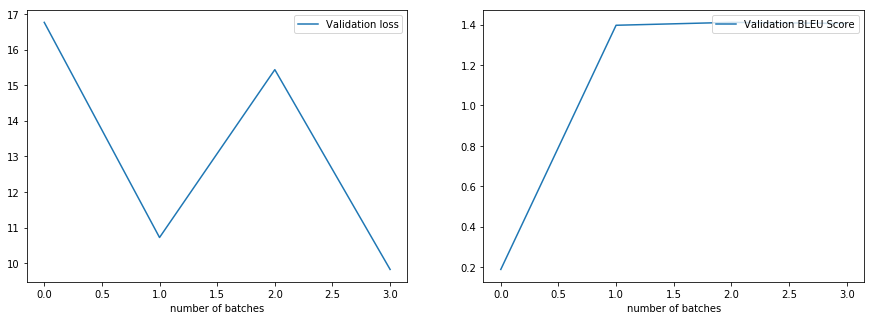

In [28]:
train_model('rnn', 'noattn', hyper)

cnn+attn

Time: 2m 1s (- -2m 59s), Epoch: [1/2], Step: [2/6669], Train Loss: 16.55219970703125, BLEU score: 0.18392036231360262
Time: 4m 6s (- -4m 55s), Epoch: [1/2], Step: [4/6669], Train Loss: 10.271667175292968, BLEU score: 1.4016658904889774
Time: 6m 22s (- -4m 48s), Epoch: [2/2], Step: [2/6669], Train Loss: 14.237471313476561, BLEU score: 1.3576332664473463
Time: 8m 31s (- -7m 36s), Epoch: [2/2], Step: [4/6669], Train Loss: 8.816268920898438, BLEU score: 1.4121792861873559


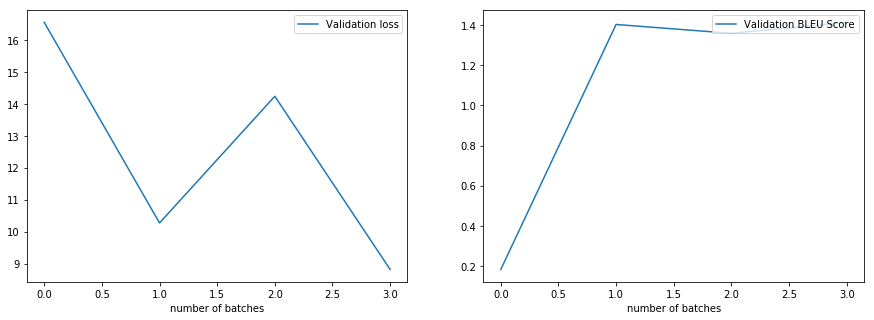

In [29]:
train_model('cnn', 'attn', hyper)

cnn+noattn

Time: 2m 40s (- -2m 39s), Epoch: [1/2], Step: [2/6669], Train Loss: 16.581331787109377, BLEU score: 0.18771740916803975
Time: 5m 0s (- -4m 14s), Epoch: [1/2], Step: [4/6669], Train Loss: 10.499592895507813, BLEU score: 0.4489147152479152
Time: 7m 45s (- -4m 7s), Epoch: [2/2], Step: [2/6669], Train Loss: 15.391780395507812, BLEU score: 1.413468997604597
Time: 10m 18s (- -8m 16s), Epoch: [2/2], Step: [4/6669], Train Loss: 9.748080749511718, BLEU score: 1.4173624798705138


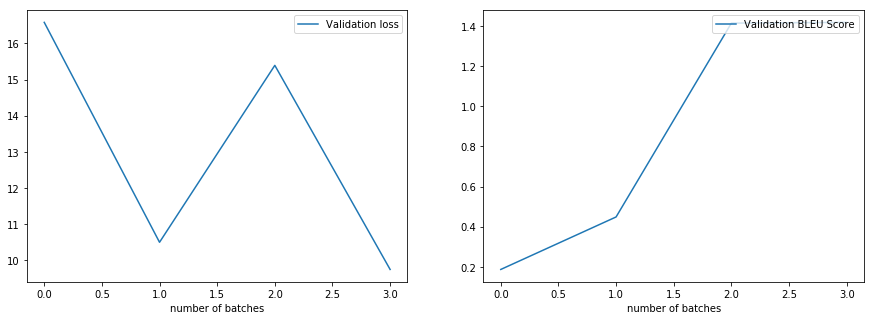

In [30]:
train_model('cnn', 'noattn', hyper)